In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of 01060602previewen-02d.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_3.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Sample13.150.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image16 (3).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_4.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of close-up-of-alluvial-soil-as-a-texturebackground-JCB3RY.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_6 - Copy.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image15 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_26.png
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image16 (

RESNET-50

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
def preprocess_image(image_path):
    """ Load and preprocess an image: CLAHE, RGB & HSV extraction, resizing, and normalization """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    
    r, g, b = cv2.split(image)
    r = cv2.addWeighted(r, 0.7, v_channel, 0.3, 0)
    g = cv2.addWeighted(g, 0.7, v_channel, 0.3, 0)
    b = cv2.addWeighted(b, 0.7, v_channel, 0.3, 0)
    
    processed_image = cv2.merge([r, g, b])
    processed_image = cv2.resize(processed_image, (224, 224))
    return processed_image / 255.0


In [5]:
def load_dataset(directory):
    """ Load dataset, apply preprocessing, and return images & labels """
    images, labels = [], []
    class_names = sorted(os.listdir(directory))  
    class_dict = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            images.append(preprocess_image(img_path))
            labels.append(class_dict[class_name])
    
    return np.array(images), np.array(labels), class_dict

In [6]:
# Load datasets
train_images, train_labels, class_dict = load_dataset("/kaggle/input/soil-types-dataset/Dataset/Train")
test_images, test_labels, _ = load_dataset("/kaggle/input/soil-types-dataset/Dataset/test")

num_classes = len(class_dict)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)


In [7]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


In [8]:
# Load ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


In [18]:
# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training
epochs = 30
batch_size = 32
history = model.fit(data_gen.flow(train_images, train_labels, batch_size=batch_size), epochs=epochs)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 56s 675ms/step - accuracy: 0.9839 - loss: 0.0409
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.9924 - loss: 0.0242
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 0.9893 - loss: 0.0364
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 0.9875 - loss: 0.0454
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.9886 - loss: 0.0362
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.9801 - loss: 0.0801
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.9921 - loss: 0.0259
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.9848 - loss: 0.0417
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.9918 - loss: 0.0572
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step - accuracy: 0.9846 - loss: 0.0471
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.9878 - loss: 0.0365
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12

In [19]:
# Save Model
model.save("resnet50_soil_model.h5")


In [20]:
# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Final Testing Accuracy: {test_acc * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.9200 - loss: 0.6875
Final Testing Accuracy: 95.29%


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step


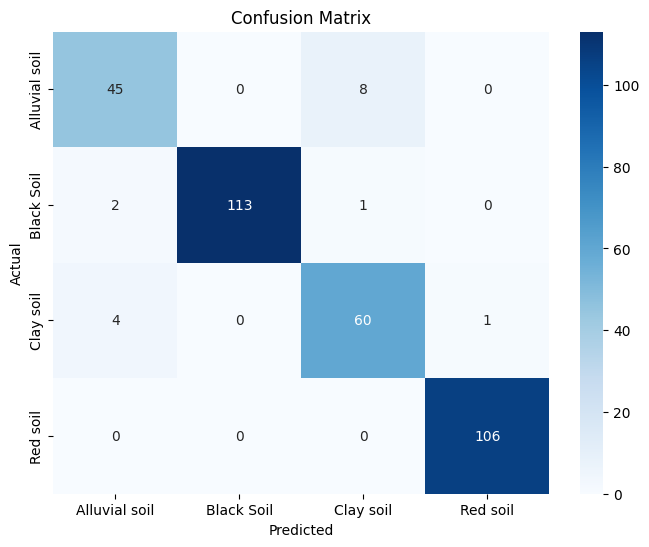

In [21]:
# Confusion Matrix
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_dict.keys(), yticklabels=class_dict.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

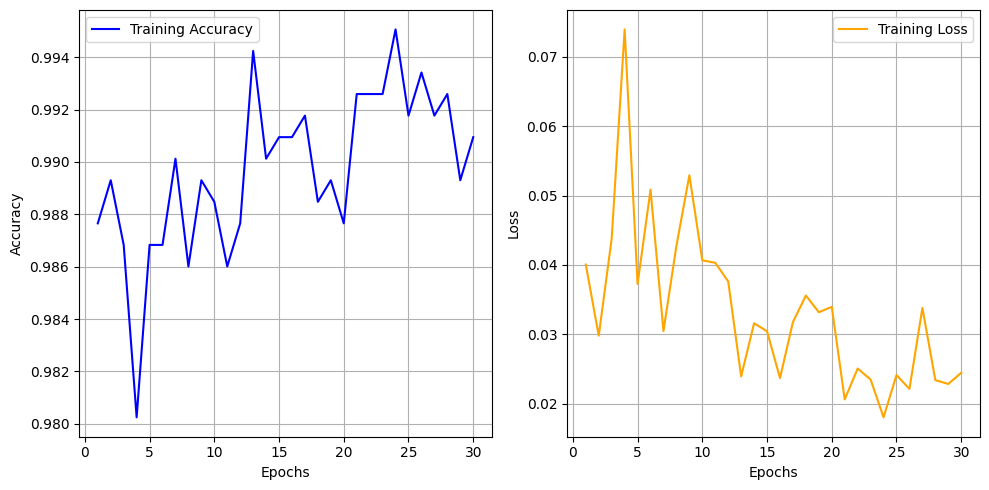

In [22]:
# Plot Training History
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)
